In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import dirichlet, poisson
from scipy.special import factorial, logsumexp
import statsmodels.api as sm
import matplotx
from multiprocessing import Pool
from time import time

plt.style.use(matplotx.styles.aura["dark"])

In [2]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i + 1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w


colors = ["tab:red", "tab:blue"]

In [3]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


In [101]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 2
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)
trial_id = []
X = []


for trial_idx in trial_indices:
    trial_start = data["trialStart"][trial_idx]
    trial_end = data["trialEnd"][trial_idx]
    trial_length = trial_end - trial_start

    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    lcue_times = data["cueOnset_L"][trial_idx]
    rcue_times = data["cueOnset_R"][trial_idx]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

   

    X.append(np.hstack((X_sr, X_sl, np.ones((X_sr.shape[0], 1)))))
    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))


trial_id = np.concatenate(trial_id).astype(int)
X = np.vstack(X)
print(f'X shape = {X.shape}')


number of trials: 290
X shape = (13238, 61)


transition matrix: 
[[0.81 0.08 0.11]
 [0.23 0.65 0.12]
 [0.02 0.   0.98]]


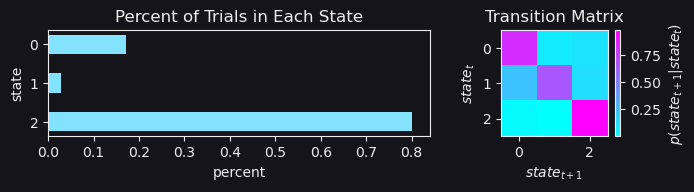

In [116]:
# Generating states for simulation
np.random.seed(0)
n_states = 3
t_init = np.array([2, 0.7, 0.7])
T_sim = np.array([dirichlet(np.roll(t_init**(n+1), n)).rvs()[0] for n in range(n_states)])
dist_init = np.array([0.8, 0.1, 0.1])
sim_states = np.ones(trial_indices.size).astype(int)
for i in range(sim_states.size):
    if i == 0:
        sim_states[i] = np.random.choice(np.arange(n_states), 1, p=dist_init)
    sim_states[i] = np.random.choice(np.arange(n_states), 1, p=T_sim[sim_states[i-1]])

print(f'transition matrix: \n{np.round(T_sim, 2)}')
fig, axs = plt.subplots(1, 2, figsize=(7, 2), gridspec_kw={'width_ratios': [5, 2]})
_ = axs[0].hist(sim_states, bins=np.arange(-0.5, 2.51, 1), density=True, rwidth=0.5, orientation='horizontal')
axs[0].set_title('Percent of Trials in Each State')
axs[0].set_xlabel('percent')
axs[0].set_ylabel('state')
axs[0].set_ylim(axs[0].get_ylim()[::-1])
im = axs[1].imshow(T_sim, cmap='cool', origin='upper')
plt.colorbar(im, ax=axs[1], label='$p(state_{t+1} | state_t)$')
axs[1].set_title('Transition Matrix')
axs[1].set_ylabel(r'$state_t$')
axs[1].set_xlabel(r'$state_{t+1}$')
plt.tight_layout()

(3, 61, 2)


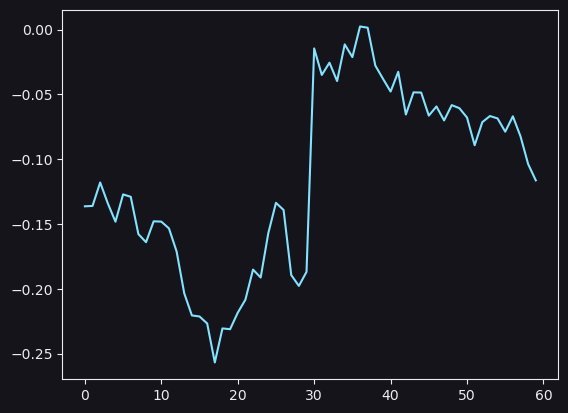

In [117]:
# generating parameters for each state for each neuron
np.random.seed(20)
n_filters = 2
theta_sim = np.empty((n_states, filt_len*n_filters+1, n_neurons))
for n in range(n_neurons):
    for s in range(n_states):
        for f in range(n_filters):  # 2 filters, right stim, left stim, (no spikes for simulated data)
            for i in range(filt_len):
                if i == 0:
                    theta_sim[s, i+(f * filt_len), n] = np.random.normal(0, 0.1)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
                else:
                    theta_sim[s, i+(f*filt_len), n] = np.random.normal(theta_sim[s, i+(f*filt_len)-1, n], .02)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
        theta_sim[s, -1, n] = np.random.normal(0.15, 0.05) #bias term

print(theta_sim.shape)
plt.plot(theta_sim[0, :-1, 1])

In [118]:
# generating spike rate data
y_sim = []
for trial in np.unique(trial_id):
    x_idx = np.argwhere(trial_id==trial)
    y_sim.append(np.squeeze(X[x_idx] @ theta_sim[sim_states[trial]]))

y_sim = np.round(np.exp(np.vstack(y_sim)))
print(y_sim.shape)
theta_sim.shape

(13238, 2)


(3, 61, 2)

In [119]:
#initial glm with no states to estimate weights
theta_init = np.empty(theta_sim[0].shape)
sta = (X.T @ y_sim) / y_sim.sum()
glms = [None for _ in range(n_neurons)]

for neuron in range(n_neurons):
    glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson())
    glms[neuron] = glm
    a = 1 * np.ones(X.shape[1])
    a[-1] = 0
    res = glm.fit_regularized(start_params=sta[:, neuron], alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

    w = res.params
    theta_init[:, neuron] = w

In [136]:
# np.random.seed(0)
n_states = 3
n_trials = trial_indices.size
theta_hmm = np.ones((n_states, X.shape[1], n_neurons)) * theta_init
# adding noise to all the weights
theta_hmm += np.random.normal(0, .01, size=theta_hmm.shape)
theta_hmm = theta_sim
t_init = np.array([5, 1, 1])
# placing higher bias on self-transition
T = np.array([dirichlet(np.roll(t_init, n)).rvs()[0] for n in range(n_states)])
T = T_sim
pi = np.log(np.ones(n_states)) - np.log(n_states)
alpha = np.empty((n_states, n_trials))
beta = np.empty(alpha.shape)
beta[:, -1] = 0
predict = np.empty(alpha.shape)
loglikeli = np.empty(alpha.shape)
xi = np.empty((n_trials-1, n_states, n_states))
scale = np.empty(n_trials)
total_ll = []

def log_space_product(A,B):
    Astack = np.stack([A]*B.shape[1]).transpose(1,0,2)
    Bstack = np.stack([B]*A.shape[0]).transpose(0,2,1)
    return logsumexp(Astack+Bstack, axis=2)


def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)



for _ in range(15):
    # expectation step:
    for t in range(0, n_trials):
        x_idx = np.argwhere(trial_id==t).squeeze()


        # predict
        if t == 0:
            predict[:, t] = pi
        else:
            pred = []
            for tran in T.T:
                pred.append(logsumexp(np.log(tran) + alpha[:, t-1]))
            # predict[:, t] = T.T @ np.exp(alpha[:, t-1])
            predict[:, t] = np.array(pred)

        v = X[x_idx] @ theta_hmm
        r = np.exp(v)
        ll = y_sim[x_idx] * np.log(r) - r
        ll = ll.sum(axis=(1,2))
        loglikeli[:, t] = ll - logsumexp(ll)

        # update
        update = loglikeli[:, t] + predict[:, t]
        scale[t] = logsumexp(update)
        update = update - scale[t]
        alpha[:, t] = update
    
        

    beta = np.empty(alpha.shape)
    beta[:, -1] = 0  # in log form
    for t in range(n_trials-2, -1, -1):
        b_up = []
        for tran in T:
            beta_update = tran + (beta[:, t+1] + loglikeli[:, t+1])
            b_up.append(logsumexp(beta_update))
        beta[:, t] = np.array(b_up) - scale[t+1]
    gamma = alpha + beta
    gamma -= logsumexp(gamma, axis=0) 

    total_ll.append((loglikeli*np.exp(gamma)).sum())

    for t in range(0, n_trials-1):
        for s1 in range(n_states):
            for s2 in range(n_states):
                xi[t, s1, s2] = np.log(T[s1, s2]) + alpha[s1, t] + loglikeli[s2, t+1] + beta[s2, t+1]

        xi[t] -= logsumexp(xi[t])
    
    T = logsumexp(xi, axis=0)
    T -= logsumexp(T, axis=1)[:, None]
    T = np.exp(T)
    _, trial_counts = np.unique(trial_id, return_counts=True)
    pi = gamma[:, 0]

    # maximization
    for s in range(n_states):
        for neuron in range(n_neurons):
            weights = np.repeat(np.exp(gamma[s]), trial_counts)
            glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson(), freq_weights=weights)

            a = 1 * np.ones(X.shape[1])
            a[-1] = 0
            res = glm.fit_regularized(start_params=sta[:, neuron], alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

            w = res.params
            theta_hmm[s, :, neuron] = w

array([[8.13126221e-01, 7.65209357e-02, 1.10352843e-01],
       [2.27686039e-01, 6.48004346e-01, 1.24309615e-01],
       [2.10012197e-02, 4.89635218e-05, 9.78949817e-01]])

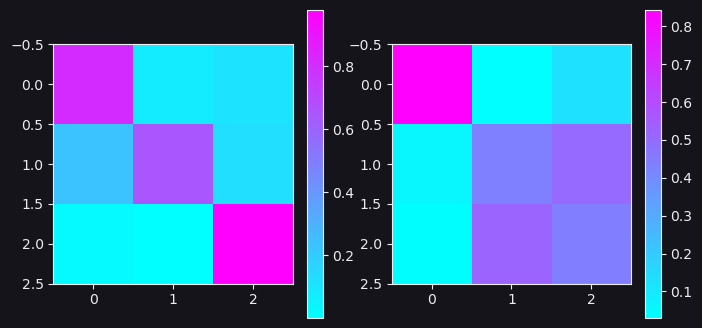

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im = axs[0].imshow(T_sim, cmap='cool')
plt.colorbar(im, ax=axs[0], fraction = 0.1)

im = axs[1].imshow(T, cmap='cool')
plt.colorbar(im, ax=axs[1], fraction = 0.1)
### try changing sim weights way more. try removing factorial? try doing wayyyy more iterations
T_sim

In [114]:
import pandas as pd
from scipy.stats import chi2_contingency
df = pd.DataFrame(np.concatenate((np.argmax(gamma, axis=0)[:, None], sim_states[:, None]), axis=1), columns = ['pred', 'truth'])
CrosstabResult=pd.crosstab(index=df['pred'],columns=df['truth'])
print(CrosstabResult)
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)

# P-Value is the Probability of H0 being True
# If P-Value&gt;0.05 then only we Accept the assumption(H0)

print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

truth    0   1  2
pred             
0      156   0  0
1        0  11  8
2       76  35  4
The P-Value of the ChiSq Test is: 1.572632226370434e-33


### actual data

In [ ]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 50
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)

trial_id = []  # this will keep track of each trial in the design matrix (since each trial spans multiple rows)
for i, neuron in enumerate(neuron_idx):
    X = []
    y = []

    for trial_idx in trial_indices:
        trial_start = data["trialStart"][trial_idx]
        trial_end = data["trialEnd"][trial_idx]
        trial_length = trial_end - trial_start
        spikes = data["spikes"][neuron]
        spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
        keyframes = data["keyFrames"][trial_idx]
        keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
        lcue_times = data["cueOnset_L"][trial_idx]
        rcue_times = data["cueOnset_R"][trial_idx]

        bins = np.arange(0, trial_length, bin_size)
        bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

        binned_stimr, _ = np.histogram(rcue_times, bins)
        binned_stiml, _ = np.histogram(lcue_times, bins)
        binned_spikes, _ = np.histogram(spikes - trial_start, bins)
        binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

        padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
        X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
        padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
        X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
        padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
        X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

        padded_spikes = np.pad(
            binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0)
        )
        X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

        X.append(np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1)))))
        y.append(binned_spikes[:, np.newaxis])
        if i == 0:
            trial_id.append(trial_idx * np.ones(X_sr.shape[0]))

    X_all.append(np.vstack(X))
    y_all.append(np.vstack(y))

trial_id = np.concatenate(trial_id)
X_all = np.array(X_all)
y_all = np.array(y_all)

In [ ]:
# def glm_fit(d):
#     x, y = d
#     glm = sm.GLM(endog=y, exog=x, family=sm.families.Poisson())

#     res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
#     return res.params

# input = tuple(zip(X_all, y_all))

# pool = Pool(10)

# w_initial = pool.map(glm_fit, input)